## Density based clustering notebook

First things first: load the libraries that we will use and set up some notebook and style related stuff.

In [31]:
%matplotlib inline
import seaborn as sns
import clustering_tools as ct
import numpy as np
import matplotlib.pyplot as plt

sns.set_style("white")

colors = ["red", "blue", "green", "orange"]

def plot_clusters(data, clusters):
    ct.draw_clusters(data, clusters, colors)

Load our first sample dataset and draw the clusters according to the "ground truth"

<module 'matplotlib.pyplot' from 'C:\\Users\\nadav\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

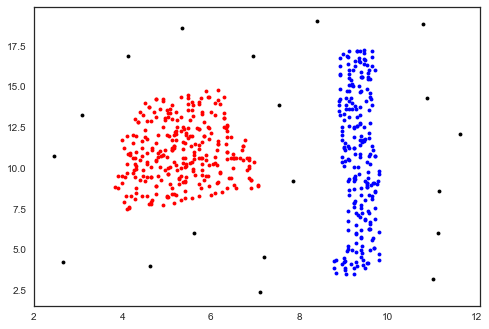

In [2]:
data, labels = ct.read_data("density.csv")
plot_clusters(data, labels)

Note that dataset also contains a bit of noise between and around the clusters.
Let's first try to run K-Means on this dataset and see how well it can cluster such dataset.

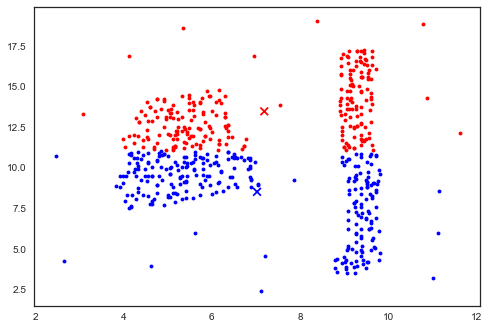

In [3]:
from sklearn.cluster import KMeans

clusters_count = np.unique(labels)
kmeans = KMeans(n_clusters=len(np.unique(labels))-1, n_init=100)
kmeans_clusters = kmeans.fit_predict(data)

plot_clusters(data, kmeans_clusters)

centers = kmeans.cluster_centers_
plt.scatter(centers[:,0], centers[:,1], marker='x', c=colors, s=60)

As you can probably see, K-Means gives sub-optimal results for such kind of datasets. Even more than that, since K-means doesn't have the notion of noise, all of the original "noise" data points must be clustered to one of the two clusters.

Instead of using K-Means, we can try and use DBSCAN.
In order to estimate DBSCAN parameter we are going to use the following common hueristic:
1. Set MinPts to the dimensiondality of the data + 1. That is MinPts=3
2. Estimate epsilon by examining the distances of every point from it's minPoints-erd neigbhor (in our case it's 3rd neighbor) in descending order. When we examine the plot, we will search for the place in the graph in which there will be a "break" before a continous, dense line.

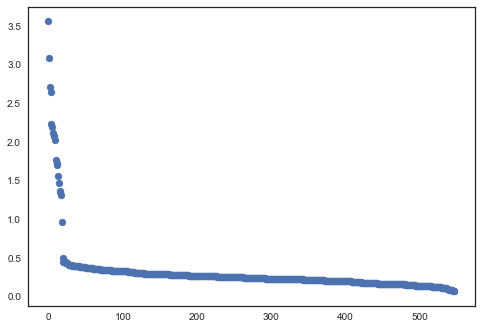

In [4]:
from sklearn.neighbors import NearestNeighbors

# set min points to d+1
min_points = 3

def plot_kth_neighbor_dists(data, k):
    nbrs = NearestNeighbors(n_neighbors=k).fit(data, data)

    distances, _ = nbrs.kneighbors()
    # get all of the distances in descendeing order
    min_points_dists = sorted(distances[:,-1], reverse=True)
    plt.figure()
    plt.scatter(np.arange(len(min_points_dists)), min_points_dists)
    
plot_kth_neighbor_dists(data, min_points)

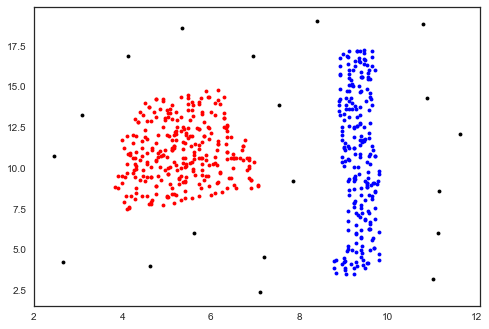

In [5]:
from sklearn.cluster import DBSCAN

def dbscan_and_plot(data, epsilon, min_pts):
    dbscan = DBSCAN(min_samples=min_points, eps=epsilon)

    dbscan_clusters = dbscan.fit_predict(data)
    plot_clusters(data, dbscan_clusters)

dbscan_and_plot(data, 0.8, min_points)
    
#ct.draw_clusters(data[dbscan.core_sample_indices_], dbscan_clusters[dbscan.core_sample_indices_], 
#                 markersize=20)

So far so good, it seems like DBSCAN can help us with finding clusters of arbitrary shapes and also identify noise.
One major drawback of DBSCAN is the fact that it assumes the same levels of densities for all clusters in the dataset.

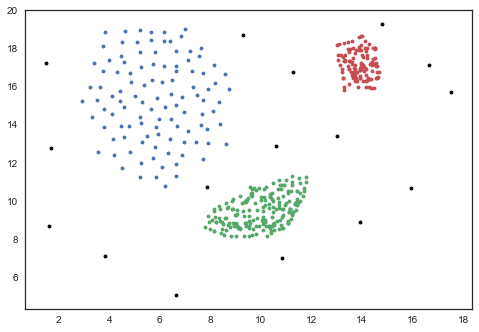

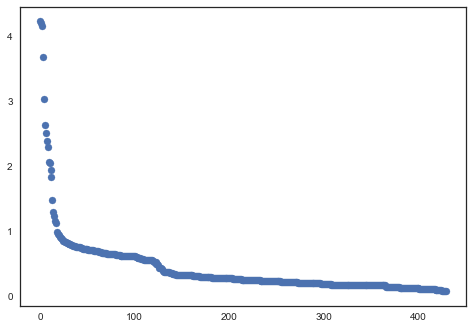

In [26]:
data2, labels2 = ct.read_data("variable_densities.csv")
plot_clusters(data2, labels2)

plot_kth_neighbor_dists(data2, min_points)

As you can see, it's not very clear from the distances plot above which value of epsilon we should choose for DBSCAN. Let's choose 2.8 as our first guess, and let's try 1.5, as both seem to be reasonable choices.

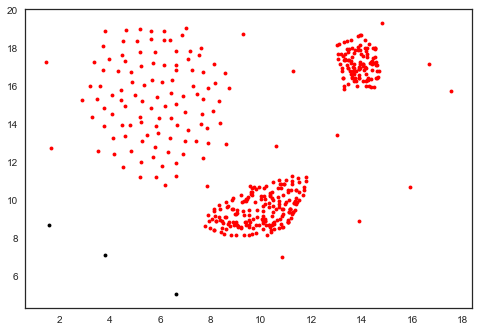

In [27]:
dbscan_and_plot(data2, 2.8, min_points)

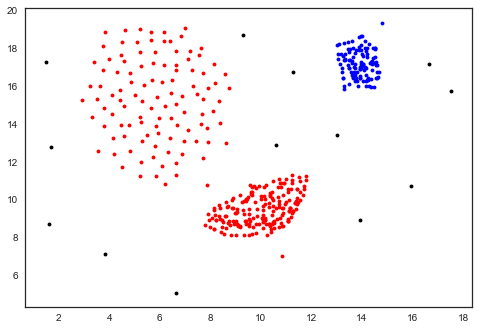

In [28]:
dbscan_and_plot(data2, 1.5, min_points)

We can first run OPTICS with a large value of epsilon and examine the reachability plot

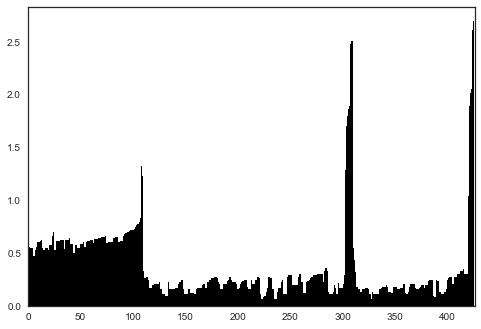

In [29]:
from pyclustering.cluster import optics
optics_instance = optics.optics(data2, minpts=min_points, eps=3);

p = optics_instance.process();

# side-node: the version that we are using here is the latest from the pyclyster dev branch
ordering = optics.ordering_analyser(optics_instance.get_ordering())
optics.ordering_visualizer.show_ordering_diagram(ordering)

One caveat of this OPTICS implementation is that it automatic cluster inference doesn't always gives the best result
Here we can do quite easy trick and use the value in the reachability plot in which the first cluster "cuts", 
which is more or less at 1.0.
We can run OPTICS again with that value of epsilon.

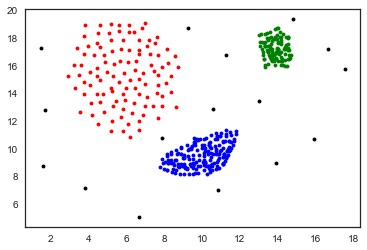

In [33]:
optics_instance = optics.optics(data2, minpts=min_points, eps=1.0);
optics_instance.process();
optics_clusters_res = optics_instance.get_clusters()
optics_clusters = -1 * np.ones(len(data2))
for cluster_index, points_in_cluster in enumerate(optics_clusters_res):
    optics_clusters[points_in_cluster] = cluster_index

plot_clusters(data2, optics_clusters)

Next up inline is HDBSCAN - instead of using OPTICS an manually inspect the reachability plot, we can just use HDBSCAN which requires only one parameter - min_cluster_size (which as you can expect, stands for the minimum number of points in a cluster)

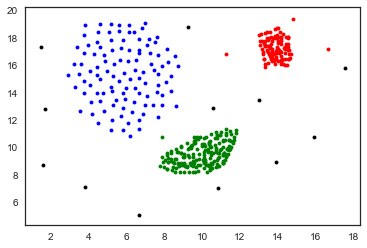

In [42]:
import hdbscan

hdbscan_instance = hdbscan.HDBSCAN(min_cluster_size=3)

# set this to true so we can draw the minimum spanning tree
hdbscan_instance.gen_min_span_tree = True

hdbscan_clusters = hdbscan_instance.fit_predict(data2)

plot_clusters(data2, hdbscan_clusters)

The HDBSCAN implementation is pretty neat and powerful, as you can see in the following cells, it let you inspect the different steps of the alogrithm, including the minimum spanning tree, the single-linkage tree, and the condensed cluter tree. 
For more information, take a look at: http://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html

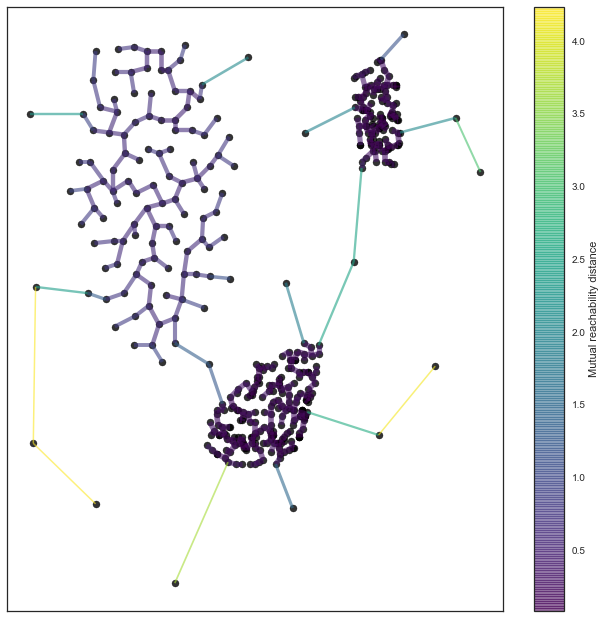

In [50]:
plt.figure(figsize=(800/72, 800/72))
hdbscan_instance.minimum_spanning_tree_.plot(edge_cmap='viridis',
                                      edge_alpha=0.6,
                                      node_size=50,
                                      edge_linewidth=1.5)

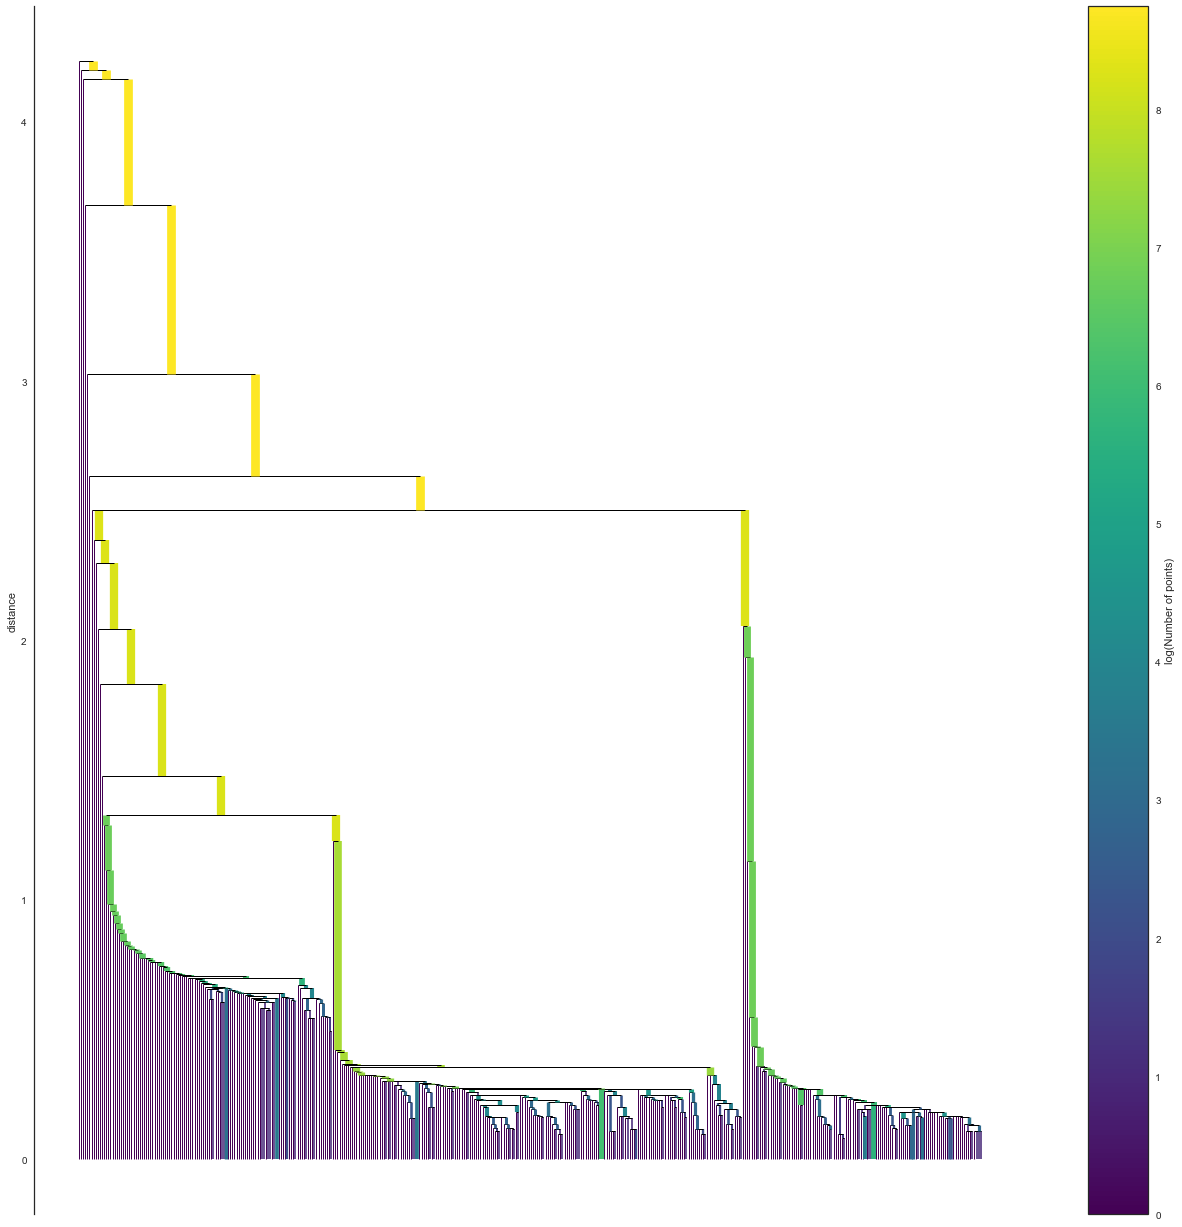

In [56]:
plt.figure(figsize=(1600/72, 1600/72))
hdbscan_instance.single_linkage_tree_.plot()

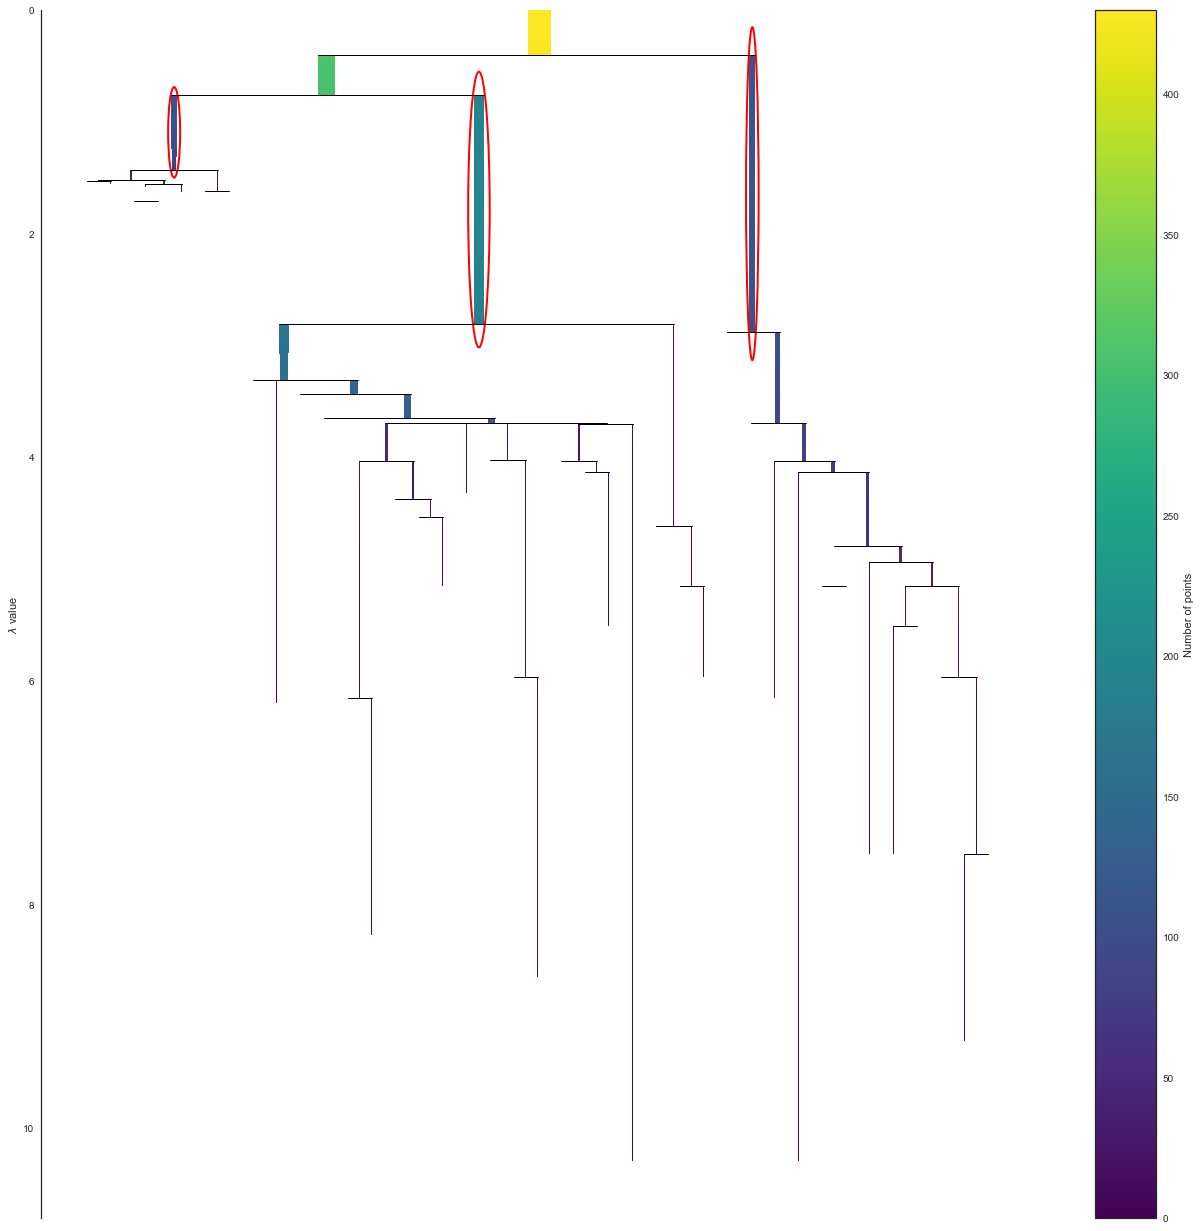

In [58]:
plt.figure(figsize=(1600/72, 1600/72))
hdbscan_instance.condensed_tree_.plot(select_clusters=True)